<span style="font-family:Papyrus; font-size:3em;">Computational Experiments</span>

<span style="font-family:Papyrus; font-size:2em;">Two Factors in Combination (TFC) Design</span>

This lecture continues the analysis of the Wolf model of glycolytic oscillations to consider the effects of two parameters in combination.

# Programming Preliminaries

In [1]:
# Code installs. Only needed once.
if False:
    !pip install matplotlib
    !pip install numpy
    !pip install pandas
    !pip install scipy
    !pip install tellurium
    !pip install seaborn

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import pandas as pd
from scipy import fftpack
import tellurium as te
import seaborn as sns

In [3]:
# Constants
AMPLIDX = 1  # Index of amplitude values
FONTSIZE = 16
FREQIDX = 0  # Index of frequency values
TIME = "time"
SMALLEST_PCT = -100  # Smallest percent change in a parameter value

In [4]:
WOLF_MODEL = """
// Created by libAntimony v2.12.0
model *Jana_WolfGlycolysis()

  // Compartments and Species:
  compartment compartment_;
  species Glucose in compartment_, fructose_1_6_bisphosphate in compartment_;
  species glyceraldehyde_3_phosphate in compartment_, glycerate_3_phosphate in compartment_;
  species pyruvate in compartment_, Acetyladehyde in compartment_, External_acetaldehyde in compartment_;
  species ATP in compartment_, ADP in compartment_, NAD in compartment_, NADH in compartment_;
  species $External_glucose in compartment_, $ethanol in compartment_, $Glycerol in compartment_;
  species $Sink in compartment_;

  // Reactions:
  J0: $External_glucose => Glucose; J0_inputFlux;
  J1: Glucose + 2 ATP => fructose_1_6_bisphosphate + 2 ADP; J1_k1*Glucose*ATP*(1/(1 + (ATP/J1_Ki)^J1_n));
  J2: fructose_1_6_bisphosphate => glyceraldehyde_3_phosphate + glyceraldehyde_3_phosphate; J2_k*fructose_1_6_bisphosphate;
  J3: glyceraldehyde_3_phosphate + NADH => NAD + $Glycerol; J3_k*glyceraldehyde_3_phosphate*NADH;
  J4: glyceraldehyde_3_phosphate + ADP + NAD => ATP + glycerate_3_phosphate + NADH; (J4_kg*J4_kp*glyceraldehyde_3_phosphate*NAD*ADP - J4_ka*J4_kk*glycerate_3_phosphate*ATP*NADH)/(J4_ka*NADH + J4_kp*ADP);
  J5: glycerate_3_phosphate + ADP => ATP + pyruvate; J5_k*glycerate_3_phosphate*ADP;
  J6: pyruvate => Acetyladehyde; J6_k*pyruvate;
  J7: Acetyladehyde + NADH => NAD + $ethanol; J7_k*Acetyladehyde*NADH;
  J8: Acetyladehyde => External_acetaldehyde; J8_k1*Acetyladehyde - J8_k2*External_acetaldehyde;
  J9: ATP => ADP; J9_k*ATP;
  J10: External_acetaldehyde => $Sink; J10_k*External_acetaldehyde;

  // Species initializations:
  Glucose = 0;
  fructose_1_6_bisphosphate = 0;
  glyceraldehyde_3_phosphate = 0;
  glycerate_3_phosphate = 0;
  pyruvate = 0;
  Acetyladehyde = 0;
  External_acetaldehyde = 0;
  ATP = 3;
  ADP = 1;
  NAD = 0.5;
  NADH = 0.5;
  External_glucose = 0;
  ethanol = 0;
  Glycerol = 0;
  Sink = 0;

  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  J0_inputFlux = 50;
  J1_k1 = 550;
  J1_Ki = 1;
  J1_n = 4;
  J2_k = 9.8;
  J3_k = 85.7;
  J4_kg = 323.8;
  J4_kp = 76411.1;
  J4_ka = 57823.1;
  J4_kk = 23.7;
  J5_k = 80;
  J6_k = 9.7;
  J7_k = 2000;
  J8_k1 = 375;
  J8_k2 = 375;
  J9_k = 28;
  J10_k = 80;

  // Other declarations:
  const compartment_, J0_inputFlux, J1_k1, J1_Ki, J1_n, J2_k, J3_k, J4_kg;
  const J4_kp, J4_ka, J4_kk, J5_k, J6_k, J7_k, J8_k1, J8_k2, J9_k, J10_k;
end
"""

In [5]:
# Constants used in the analysis of the Wolf model
WOLF_RR = te.loada(WOLF_MODEL)
START = 0
END = 5
NUMPT = 300  # number of points to simulate
WOLF_DATA = WOLF_RR.simulate(START, END, NUMPT)
WOLF_PRMS = [
  "J0_inputFlux", "J1_k1", "J1_Ki", "J1_n", "J2_k", "J3_k", "J4_kg", "J4_kp",
 "J4_ka", "J4_kk", "J5_k", "J6_k", "J7_k", "J8_k1", "J8_k2", "J9_k", "J10_k",     
]

# Design

A TFC design is used to identify interactions between factors.
This means that there is an experiment for every combination of levels of both factors.
That is, there are $n_1 \times n_2$ experiments if there are $n_i$ levels of the two factors.

## Challenge: Reducing combinatorics

A first challenge with a TFC is the number of constants that must be estimated.
For example, the Wolf model has 16 parameters, which means that there are 120 interactions, each of which need to be calculated at several levels.
With 10 levels for each interaction, this results in $10 \times 10 \times 120 = 12,000$ constants to calculate.

**Questions**
1. What are some approaches to reducing the number of constants to estimate in a TFC design?
1. What interaction terms should be estimated for the Wolf model?

## Challenge: Visualization

**Questions**
1. How should we present the responses that clearly presents which interaction terms are displayed, their values, and patterns in the responses?

# Codes from OFT Design

## runSimulation(parameterDct, roadrunner=None)->dict{parameter: percentChange}

In [6]:
def runSimulation(parameterDct, roadrunner=None):
    """
    Runs a simulation for parameters with percentage changes from baseline values.

    Parameters
    ----------
    parameterDct: dict
       key: parameter
       value: float
           percent change
       
    Returns
    -------
    namedArray: results of simulation
    """
    if roadrunner is None:
        roadrunner = te.loada(WOLF_MODEL)
    else:
        roadrunner.resetAll()
    for parameter, percent in parameterDct.items():
        baseValue = roadrunner[parameter]
        roadrunner[parameter] = baseValue*(1 + 0.01*percent)
    # Run the simulation
    data = roadrunner.simulate(START, END, NUMPT)
    return data

#Test
assert(len(runSimulation({"J1_Ki": 0.2})) > 0)

## calculateFft(molecule, data) -> list-amplitudes, list-frequenceis

In [7]:
def calculateFft(molecule, data, offset=100):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.
    
    Parameters
    ----------
    molecule: str
    data: NamedArray
    offset: int
        Initial data that are not included in the FFT calculation
             
    Returns
    -------
    list-float, list-float
        freqs, fftValues
    """
    # Returns frequencies and abs(fft) for a chemical species (molecule)
    col = "[%s]" % molecule
    values = data[col]
    numPoint = len(data)
    count = numPoint - offset
    endTime = data["time"][-1]
    freqs = fftpack.fftfreq(count, endTime/numPoint)
    fftValues = np.abs(fftpack.fft(values[offset:]))
    # Eliminate frequency of 0
    freqs = freqs[1:]
    fftValues = fftValues[1:]
    return freqs, fftValues

# Tests
freqs, fftValues = calculateFft("Glucose", WOLF_DATA)
assert(max(fftValues) > 90)  # Top frequency should have a large magnitude

## getFrequencyAmplitude(molecule, data)->frequency, amplitude

In [8]:
def getFrequencyAmplitude(molecule, data):
    """
    Obtains the highest amplitude frequency and value for the molecule.
    
    Parameters
    ----------
    molecule: str
    data: NamedArray
    
    Returns
    -------
    frequency: float
    amplitude: float
    """
    # Return True if the expected frequency is among the topN frequencies with the largest amplitudes
    frequencies, amplitudes = calculateFft(molecule, data=data)
    # Find the indices of the largest amplitudes
    sortedIndices = sorted(range(len(frequencies)), key=lambda i: amplitudes[i], reverse=True)
    topIdx = sortedIndices[0]
    return frequencies[topIdx], amplitudes[topIdx]

# Tests
frequency, amplitude = getFrequencyAmplitude("Glucose", WOLF_DATA)
assert(frequency > 5.0)
assert(amplitude > 90)

## calculateFft(molecule, data)->list-freq, list-fftValues

In [9]:
def calculateFft(molecule, data, offset=100):
    """
    Calculate the FFT for a molecule in the simulation output.
    The calculation does not include amplitudes at a frequency of 0.
    
    Parameters
    ----------
    molecule: str
    data: NamedArray
    offset: int
        Initial data that are not included in the FFT calculation
        
    Returns
    -------
    list-float, list-float
        freqs, fftValues
    """
    # Returns frequencies and abs(fft) for a chemical species (molecule)
    col = "[%s]" % molecule
    values = data[col]
    numPoint = len(data)
    count = numPoint - offset
    endTime = data["time"][-1]
    freqs = fftpack.fftfreq(count, endTime/numPoint)
    fftValues = np.abs(fftpack.fft(values[offset:]))
    # Eliminate frequency of 0
    freqs = freqs[1:]
    fftValues = fftValues[1:]
    return freqs, fftValues

# Tests
freqs, fftValues = calculateFft("Glucose", WOLF_DATA)
assert(max(fftValues) > 90)  # Top frequency should have a large magnitude

## runExperiment(parameterDct)->frequencySer, amplitudeSer

In [10]:
def runExperiment(parameterDct):
    """
    Runs an experiment by changing parameters by the specified fractions and calculating responses.
    
    Parameters
    ----------
    parameterDct: dict
       key: parameter name
       value: percent change the parameter
       
    Returns
    -------
    frequencySer: pd.Series
        index: molecule
        value: frequency with largest amplitude
    amplitudeSer: pd.Series
        index: molecule
        value: largest amplitude
    """
    data = runSimulation(parameterDct)
    frequencyDct = {}
    amplitudeDct = {}
    molecules = [s[1:-1] for s in data.colnames if s != TIME]
    for molecule in molecules:
        frequency, amplitude = getFrequencyAmplitude(molecule, data)
        frequencyDct[molecule] = frequency
        amplitudeDct[molecule] = amplitude
    return pd.Series(frequencyDct), pd.Series(amplitudeDct)

# Test
frequencySER, amplitudeSER = runExperiment({"J1_Ki": 0.03})
assert(len(frequencySER) == len(amplitudeSER))

## runExperiments(parameter, percents, isRelative) -> frequencyDF, amplitudeDF

In [11]:
def runExperiments(parameter, percents, isRelative=True):
    """
    Runs experiments for one parameter of the model at different percent changes in the parameter value (levels).
    
    Parameter
    ---------
    parameter: str
    percents: list-float
        percent change in parameter
    isRelative: bool
        True: values are percent changes relative to baseline
        False: absolute value
        
    Returns
    -------
    frequencyDF: DataFrame
        index: percent
        columns: molecule
        values: percent change in frequency w.r.t. baseline
    amplitudeDF: DataFrame
        index: percent
        columns: molecule
        values: depends on isRelative
    """
    # Calculate the baseline values
    baseFrequencySer, baseAmplitudeSer = runExperiment({})
    #
    def calc(ser, isFrequency=True):
        if not isRelative:
            return ser
        if isFrequency:
            baseSer = baseFrequencySer
        else:
            baseSer = baseAmplitudeSer
        resultSer = 100*(ser - baseSer)/baseSer
        return resultSer
    #
    def iterateLevels(isFrequency=None):
        if isFrequency is None:
            raise ValueError("Must specify isFrequency!")
        sers = []  # Collection of experiment results
        for percent in percents:
            parameterDct = {parameter: percent}
            frequencySer, amplitudeSer = runExperiment(parameterDct)
            if isFrequency:
                ser = frequencySer
            else:
                ser = amplitudeSer
            adjSer = calc(ser, isFrequency=isFrequency)
            sers.append(pd.DataFrame(adjSer).transpose())
        resultDF = pd.concat(sers)
        resultDF.index = percents
        return resultDF
    #
    frequencyDF = iterateLevels(isFrequency=True)
    amplitudeDF = iterateLevels(isFrequency=False)
    return frequencyDF, amplitudeDF

# Tests
percents = [-7, 0, 7]
fDF, aDF = runExperiments("J1_Ki", percents)
assert(np.isclose(fDF.loc[percents[0], "Glucose"], -1*fDF.loc[percents[-1], "Glucose"]) )
assert(aDF.loc[percents[-1], "Glucose"] < 0 )
assert(aDF.loc[percents[0], "Glucose"] > 0 )

# Generalize runExperiments
Generalize ``runExperiments`` so that it calculates responses for all combinations of levels of two parameters.

In [12]:
def runExperimentsTwoParameters(parameter1, parameter2, percent1s, percent2s, isRelative=True):
    """
    Runs experiments for changes in multipleparameters of the model at different percent changes in the parameter value (levels).
    
    Parameter
    ---------
    parameter1: str
    parameter2: str
    percent1s: list-int
    percent2s: list-int
    isRelative: bool
        True: values are percent changes relative to baseline
        False: absolute value
        
    Returns
    -------
    frequencyDF: DataFrame, amplitude: DataFrame
       index: tuple of percent changes in parameter values
       columns: molecule
       value: depends on isRelative
       index.name: string of tuple (rowParameter, columnParameter)
    """
    INDEX1 = "index1"
    INDEX2 = "index2"
    # Calculate the baseline values
    baseFrequencySer, baseAmplitudeSer = runExperiment({})
    #
    def calc(ser, isFrequency=True):
        if not isRelative:
            return ser
        if isFrequency:
            baseSer = baseFrequencySer
        else:
            baseSer = baseAmplitudeSer
        resultSer = 100*(ser - baseSer)/baseSer
        return resultSer
    #
    def iterateLevels(isFrequency=None):
        if isFrequency is None:
            raise ValueError("Must specify isFrequency!")
        sers = []  # Collection of experiment results
        index1 = []
        index2 = []
        for percent1 in percent1s:
            for percent2 in percent2s:
                #indices.append("%d_%d" % (percent1, percent2))
                index1.append(percent1)
                index2.append(percent2)
                parameterDct = {parameter1: percent1, parameter2: percent2}
                frequencySer, amplitudeSer = runExperiment(parameterDct)
                if isFrequency:
                    ser = frequencySer
                else:
                    ser = amplitudeSer
                adjSer = calc(ser, isFrequency=isFrequency)
                sers.append(pd.DataFrame(adjSer).transpose())
        resultDF = pd.concat(sers)
        resultDF[INDEX1] = index1
        resultDF[INDEX2] = index2
        resultDF = resultDF.set_index([index1, index2])
        for column in [INDEX1, INDEX2]:
            del resultDF[column]
        resultDF.index.name = str((parameter1, parameter2))
        return resultDF
    #
    frequencyDF = iterateLevels(isFrequency=True)
    amplitudeDF = iterateLevels(isFrequency=False)
    return frequencyDF, amplitudeDF

# Tests
percents = [-7, -5, -2, 0, 2, 5, 7]
fDF, aDF = runExperimentsTwoParameters("J1_Ki", "J1_k1", percents, percents)
assert(aDF.loc[(percents[-1], percents[-1]), "Glucose"] < 0 )
assert(fDF.loc[(percents[0], percents[0]), "Glucose"] < 0 )

In [13]:
# Test Data
TEST_FDF = fDF
TEST_ADF = aDF

**Questions**
1. Display the amplitude response if there is no change in either J1_Ki or J1_k1.
1. Display the amplitude responses for J1_Ki is 0% and all changes in J1_k1.

In [14]:
# Solution 1
print("** Solution to 1:\n")
print(aDF.loc[(0,0), :])

# Solution 2
indices = [(0, p) for p in percents]
print("\n\n** Solution to 2:\n")
print(aDF.loc[indices, :])

** Solution to 1:

Glucose                       0.0
fructose_1_6_bisphosphate     0.0
glyceraldehyde_3_phosphate    0.0
glycerate_3_phosphate         0.0
pyruvate                      0.0
Acetyladehyde                 0.0
External_acetaldehyde         0.0
ATP                           0.0
ADP                           0.0
NAD                           0.0
NADH                          0.0
Name: (0, 0), dtype: float64


** Solution to 2:

        Glucose  fructose_1_6_bisphosphate  glyceraldehyde_3_phosphate  \
0 -7   4.095163                   3.969873                    5.987780   
  -5 -16.194219                 -16.195092                  -16.874792   
  -2 -10.167903                 -10.958226                  -10.307399   
   0   0.000000                   0.000000                    0.000000   
   2  -1.490985                  -0.508779                   -2.969398   
   5 -24.531760                 -22.903761                  -26.759622   
   7 -31.378887                 -31.092

# Visualizing results of an Experiment

We will visualize the TFC reponses using a heatmap. The horizontal and vertical axes
will be percent changes in parameter values; cells will be colored with the change in magnitude.

## Example of a heatmap in python

The example below generates a heatmap from a pandas DataFrame. 
The horizontal axis are the column names; the vertical axis are the values of the index of the DataFrame.
Values are encoded as a heat representation from 0 to 1.0.

In [15]:
# DataFrame
df = pd.DataFrame({"a": np.random.random(5), "b": np.random.random(5)})
df.index = [10*v for v in range(len(df))]
df

,a,b
0,0.548793,0.467717
10,0.940670,0.509726
20,0.262789,0.069915
30,0.385499,0.769735
40,0.615921,0.846606


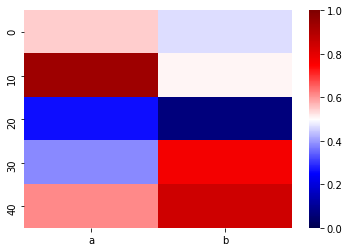

In [16]:
# Generating the heatmap
_ = sns.heatmap(df, cmap='seismic', vmin=0, vmax=1)

## Heat map for two parameters in combination

**Question**
1. Generate a heatmap for the results of experiments varying the parameters "J1_k1" and "J1_Ki" in combination
for levels -10, -5, 0, 5, 10.
The names of molecules should be the rows.

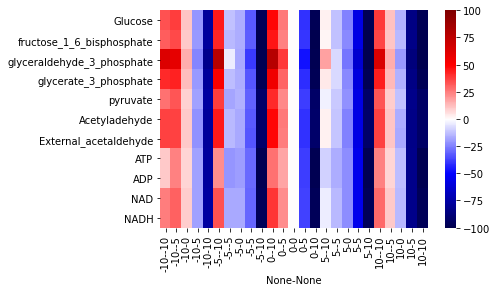

In [17]:
percents = [-10, -5, 0, 5, 10]
fDF, aDF = runExperimentsTwoParameters("J1_k1", "J1_Ki", percents, percents)
_ = sns.heatmap(aDF.transpose(), cmap='seismic', vmin=-100, vmax=100)

**Question**
1. Create a function that transforms the frequency (or amplitude) DataFrame so that rows are values of parameter 1, columns are values of parameter 2,
and cells are values of a designated molecule.

In [18]:
def pivotResponse(responseDF, molecule):
    """
    Creates a DataFrame in which values of the parameters are rows and columns.
    
    Parameters
    ----------
    responseDF: DataFrame
        columns: molecule names
        rows: tuple of percent changes in parameters
        values: response
        index.name: string of tuple (rowParameter, columnParameter)
    molecule: str
        
    Returns
    -------
    DataFrame
        columns: values of columnParameter
        rows: values of rowParameter
        cells: response for molecule
    """
    LEVEL0 = "level_0"
    LEVEL1 = "level_1"
    df = responseDF.reset_index()
    resultDF = pd.pivot_table(df, values=molecule, index=LEVEL0, columns=LEVEL1)
    parameters = eval(responseDF.index.name)
    resultDF.index.name = parameters[0]
    resultDF.columns.name = parameters[1]
    return resultDF

# Tests
df = pivotResponse(TEST_FDF, "Glucose")
#pd.pivot_table(df, values="Glucose", index="level_0", columns="level_1")
assert(len(df.index) == len(df.columns))

**Question**
1. Write a function that constructs a heatmap that displays interaction results for a single molecule (e.g., Glucose) and has rows that are changes to one parameter and columns that are changes to the other parameter. The function should return the axis.

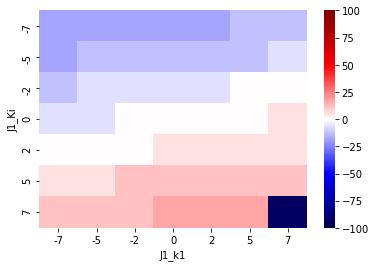

In [19]:
def makeHeatmap(responseDF, molecule, isColorbar=True, ax=None, vmin=-100, vmax=100, cbar_ax=None):
    """
    Creates a heatmap showing the interactions of response values for two parameters.
    
    Parameters
    ----------
    reponseDF: DataFrame
        index: tuples of percent changes in parameter values
        columns: molecule
        values: response
    molecule: str
    isColorbar: bool
        show the colorbar
    vmin: float
        minimum value in color bar
    vmax: float
        maximum value in color bar
    cbar_ax: Axes
    """
    df = pivotResponse(responseDF, molecule)
    if ax is None:
        ax = sns.heatmap(df, cmap='seismic', vmin=vmin, vmax=vmax, cbar=isColorbar, cbar_ax=cbar_ax)
    else:
        _ = sns.heatmap(df, cmap='seismic', vmin=vmin, vmax=vmax, cbar=isColorbar, ax=ax, cbar_ax=cbar_ax)
    return ax

# Tests
_ = makeHeatmap(TEST_FDF, "ATP")

# Running a Study

**Question**
1. Write a function that generates an upper triangular matrix of plots labelled with the interactions between parameter pairs.

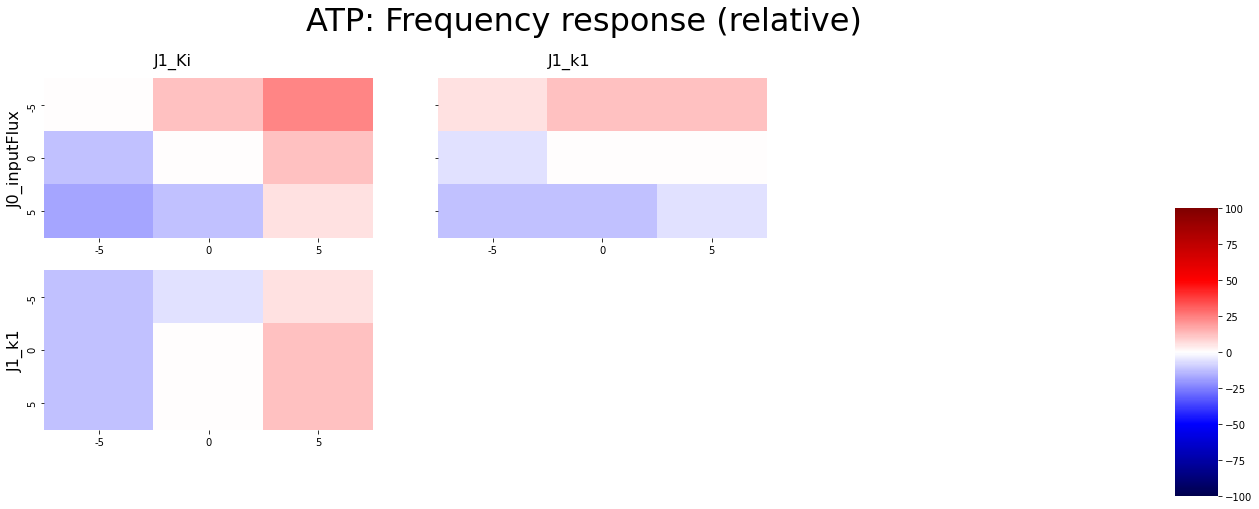

In [20]:
def runStudyTFC(molecule, parameters, percents, isRelative=True, isFrequency=True, figsize=(20, 10)):
    """
    Creates an upper triangular plot of the interactions between parameter pairs in combinations.
    
    Parameters
    ----------
    molecule: str
    parameters: list-str
    percents: list-int
    isRelative: bool
       Results are percent change w.r.t. base
    isFrequency: bool
       Results are for frequencies
    figisze: tuple-int
       Size of figures
    """
    numParameter = len(parameters)
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(numParameter, numParameter)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    for rowIdx in range(numParameter):
        parmRowidx = rowIdx
        for colIdx in range(numParameter-rowIdx-1):
            parmColidx = numParameter - colIdx - 1
            frequencyDF, amplitudeDF = runExperimentsTwoParameters(
                parameters[parmRowidx], parameters[parmColidx], 
                percents, percents, isRelative=isRelative)
            if isFrequency:
                responseDF = frequencyDF
            else:
                responseDF = amplitudeDF
            ax = plt.subplot(gs[rowIdx, colIdx])
            if rowIdx == 0:
                ax.text(1, -0.25, parameters[parmColidx], fontsize=FONTSIZE)
            if (rowIdx == numParameter - 2):
                _ = makeHeatmap(responseDF, molecule, ax=ax, isColorbar=True, cbar_ax=cbar_ax)
            else:
                _ = makeHeatmap(responseDF, molecule, ax=ax, isColorbar=False)
            ax.set_xlabel("")
            if colIdx == 0:
                ax.set_ylabel(parameters[parmRowidx], fontsize=FONTSIZE)
            else:
                ax.set_ylabel("")
                ax.set_yticklabels([])
    if isFrequency:
        responseType = "Frequency"
    else:
        responseType = "Amplitude"
    if isRelative:
        metricType = "relative"
    else:
        metricType = "absolute"
    suptitle = "%s: %s response (%s)" % (molecule, responseType, metricType)
    plt.suptitle(suptitle, fontsize=2*FONTSIZE)

# Smoke test
runStudyTFC("ATP", WOLF_PRMS[0:3], [-5, 0, 5], isRelative=True, isFrequency=True)    

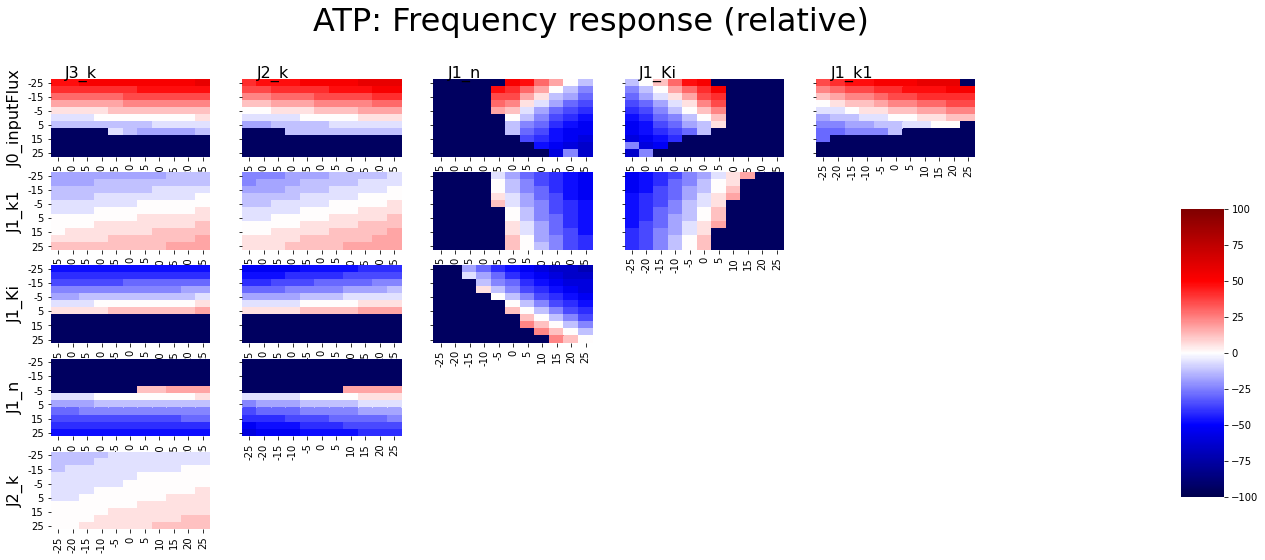

In [21]:
# Analysis for frequency with relative (precentage) responses
percents = 5*(np.array(range(11)) - 5)
runStudyTFC("ATP", WOLF_PRMS[0:6], percents, isRelative=True, isFrequency=True)    